In [1]:
# Enables/disables interactive visualization
interactive = False

# import packages
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data

from dipy.viz import window, actor, has_fury

print('import complete.')

import complete.


In [2]:
# load data
hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
label_fname = get_fnames('stanford_labels')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

white_matter = (labels == 1) | (labels == 2)

print('data loading complete.')

data loading complete.


In [3]:
# white matter mask
white_matter = (labels == 1) | (labels == 2)

In [4]:
'''
# getting directions from diffusion dataset. 
# fit data with Constant Solid Angle ODF Model,-
# - where the peaks is used for the estimation of orientation of tract/segment -
# - for each voxel
'''

from dipy.reconst.csdeconv import auto_response
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)
csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=white_matter)

print('direction computation complete. ')

In [5]:
# # visualize (quality control)
# if has_fury:
#     ren = window.Scene()
#     ren.add(actor.peak_slicer(csa_peaks.peak_dirs,
#                               csa_peaks.peak_values,
#                               colors=None))

#     window.record(ren, out_path='csa_direction_field.png', size=(900, 900))

#     if interactive:
#         window.show(ren, size=(800, 800))

In [6]:
# set constraints
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, .25)

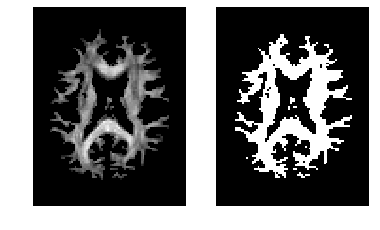

In [7]:
# visualize (quality control)
%matplotlib inline
import matplotlib.pyplot as plt

sli = csa_peaks.gfa.shape[2] // 2
plt.figure('GFA')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(csa_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((csa_peaks.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')


In [8]:
# set seeds
from dipy.tracking import utils

seed_mask = (labels == 2)
seeds = utils.seeds_from_mask(seed_mask, affine, density=[2, 2, 2])

In [9]:
# start traking, with EuDX (deterministic)
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,
                                      affine=affine, step_size=.5)
# Generate streamlines object
streamlines = Streamlines(streamlines_generator)

print('traking complete.')

traking complete.


In [10]:
# visualzie (quality control)

from dipy.viz import colormap

if has_fury:
    # Prepare the display objects.
    color = colormap.line_colors(streamlines)

    streamlines_actor = actor.line(streamlines,
                                   colormap.line_colors(streamlines))

    # Create the 3D display.
    r = window.Scene()
    r.add(streamlines_actor)

    # Save still images for this static example. Or for interactivity use
    window.record(r, out_path='tractogram_EuDX.png', size=(800, 800))
    if interactive:
        window.show(r)